In [1]:
import gym
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def action_inverse(list_oh_actions):
    ans = 0
    if int(list_oh_actions[1]) == 1:
        ans = 1
    if int(list_oh_actions[2]) == 1:
        ans = 2
    if int(list_oh_actions[3]) == 1:
        ans = 3

    return ans


def fancy_visual(value_func, policy_int):
    grid = 4
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func, (grid, grid))
    seaborn.heatmap(reshaped, cmap="icefire", vmax=1.1, robust=True,
                    square=True, xticklabels=grid + 1, yticklabels=grid + 1,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i + 0.5, j + 0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i + 0.5, j + 0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i + 0.5, j + 0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i + 0.5, j + 0.7, u'\u2192', fontsize=12)
            counter = counter + 1

    plt.title('Heatmap of value iteration with value function values and directions')
    print('Value Function', value_func)
    print('Policy', policy_int)
    plt.savefig("heatmap_vi.png", dpi=300)
    plt.show()


def calc_vi_v_s(state, value_function, P, gamma):
    dict_state = P[state]
    max_val_s_a = -1
    for action, dict_action in dict_state.items():
        cumulative_reward = 0
        for prob_ns_r, next_state, reward, is_terminal in dict_action:
            cumulative_reward += prob_ns_r * (reward + gamma * value_function[next_state])
        if max_val_s_a < cumulative_reward:
            max_val_s_a = cumulative_reward
    return max_val_s_a


def choose_action(state, value_function, P, gamma):
    dict_state = P[state]
    best_action = 0
    max_val_s_a = 0
    for action, dict_action in dict_state.items():
        cumulative_reward = 0
        for prob_ns_r, next_state, reward, is_terminal in dict_action:
            cumulative_reward += prob_ns_r * (reward + gamma * value_function[next_state])
        if max_val_s_a < cumulative_reward:
            max_val_s_a = cumulative_reward
            best_action = action
    return best_action


def policy_improvement(P, nS, nA, value_from_policy, gamma):
    new_policy = np.zeros([nS, nA])

    for state, dict_state in P.items():
        new_action = choose_action(state, value_from_policy, P, gamma)
        new_policy[state][new_action] = 1.0
    return new_policy


def value_iteration(P, nS, nA, V, gamma, delta=1e-3):
    v_k_diff = []
    V_new = V.copy()
    while True:
        temp_v = V_new.copy()
        for state, dict_state in P.items():
            V_new[state] = calc_vi_v_s(state, temp_v, P, gamma)
        diff = np.abs(temp_v - V_new)
        v_k_diff.append(np.linalg.norm(diff, ord=2))
        diff = np.max(diff)
        if diff <= delta:
            break

    policy_new = policy_improvement(P, nS, nA, V_new, gamma)

    num_iterations = [i for i in range(len(v_k_diff))]
    plt.plot(num_iterations, v_k_diff)
    plt.xlabel("Number of iterations")
    plt.ylabel("Value Difference")
    plt.title("Value Contraction")
    plt.savefig("Value_iteration_Contraction.png", dpi=300)
    plt.show()

    return policy_new, V_new


def calc_q_from_v(opt_value, env, gamma=0.9):
    q_val_tab = np.zeros((env.observation_space.n, env.action_space.n))

    for state in range(env.observation_space.n):
        for action in range(env.action_space.n):
            q_val = 0
            for P in env.P[state][action]:
                reward = P[2]
                next_state = P[1]
                q_val += P[0] * (reward + gamma * opt_value[next_state])
            q_val_tab[state][action] = q_val
    return q_val_tab


def perform_value_iteration():
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    env = env.unwrapped

    gamma = 0.9

    np.random.seed(10000)
    V1 = np.random.rand(env.observation_space.n)
    policy, value = value_iteration(env.P, env.observation_space.n, env.action_space.n, V1, gamma)
    policy_int = [action_inverse(list_oh_actions) for list_oh_actions in policy]
    q_values = calc_q_from_v(value, env, gamma)
    fancy_visual(value, policy_int)
    print(q_values)



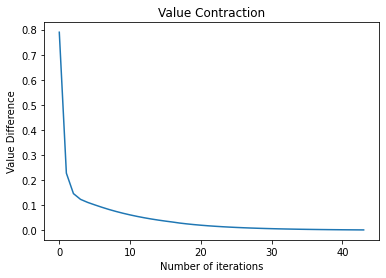

Value Function [0.07228373 0.06446338 0.07704069 0.05849716 0.09515994 0.00117124
 0.11436737 0.00079547 0.14857461 0.25040315 0.30226371 0.00865173
 0.00234776 0.38282601 0.64186205 0.00277676]
Policy [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


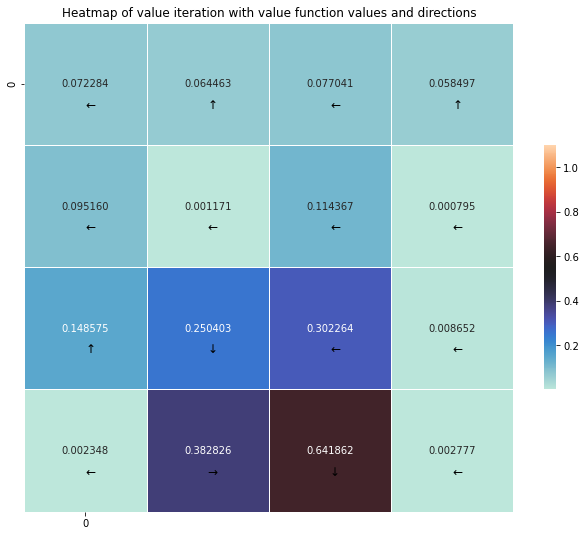

[[0.07191822 0.06957212 0.06957212 0.06270925]
 [0.04137551 0.0451487  0.04280259 0.06413634]
 [0.07676143 0.07119837 0.07497156 0.06000037]
 [0.04089999 0.04089999 0.03533694 0.0582105 ]
 [0.09480549 0.07347174 0.06660888 0.05058448]
 [0.00105412 0.00105412 0.00105412 0.00105412]
 [0.11414269 0.09126912 0.11402996 0.02370222]
 [0.00071592 0.00071592 0.00071592 0.00071592]
 [0.07382469 0.12039766 0.10437326 0.14824131]
 [0.15977156 0.2500993  0.20587829 0.13560287]
 [0.30198977 0.27027508 0.22946434 0.11202667]
 [0.00778656 0.00778656 0.00778656 0.00778656]
 [0.00211298 0.00211298 0.00211298 0.00211298]
 [0.19067308 0.30811075 0.38252736 0.26838389]
 [0.39808553 0.64157278 0.61740409 0.53969327]
 [0.00249908 0.00249908 0.00249908 0.00249908]]


In [2]:
perform_value_iteration()